# 地理曲面的拓扑测量

[*Levi John Wolf*](https://github.com/ljwolf)

In [1]:
import geopandas, numpy
import matplotlib.pyplot as plt
from esda import topo
from libpysal import weights

本手册解释了 `topo` 函数、`prominence` 和`isolation` 的用法和含义。这两个概念都源于*地形*，即研究表面的形状和特征。

从这个意义上说，地形测量侧重于表面的形状。在自然地理中，"优势 "和 "孤立 "都是地形测量，指的是一座山相对于其地貌的高度（或 "优势 "程度）。在数学上，如果我们用一个曲面（如数字高程模型或 DEM）来表示 "海拔"，那么这就成了描述一个给定曲面的局部最大值、最小值和/或鞍点的一种方法。这样，"优势"（和 "隔离"）就与曲面的局部极值和凹凸错综复杂地联系在了一起，并提供了思考地理分布结构的有用方法。从物理意义上讲，山峰的 "隔离度 "是指*在地表上找到一个更高点所需的距离。*因此，维基百科上给出的常见例子是，珠穆朗玛峰具有 "无限 "隔离度，因为它是地球表面的最高点。附近的 K2 峰是地球上第二高的山峰，与珠穆朗玛峰相对较近，因此 K2 峰的隔离度很低。然而，西半球最高的山峰阿空加比K2矮1000米左右，但隔离度*高，因为从它到最近的最高点的距离非常大。因此，"孤立性 "是对*水平*距离的衡量。

与此相反，"突出度 "是*垂直*距离的量度，描述了山峰的海拔高度与其母峰之间*"最高 "低点之间的*差距。从概念上讲，想象一下整个世界都被洪水淹没了，一直淹到珠穆朗玛峰的山顶。让我们用 $h_i$ 表示山峰的高度，用 $w$ 表示水位。因此，从 $max(h_i) = w$ 开始，我们降低水位。当 $h_i = w$ 时，一座山峰就会从水中 "冒 "出来。想象两个高度分别为 $h_i$ 和 $h_j$ 的山峰（使得 $h_i > h_j$）。然后，想象 $w$ 落到一个点 $w^* < h_j < h_i$，在这个点上，$h_i$ 和$h_j$"连接 "在一起，成为一块陆地的一部分。然后，$h_j$的*显著性计算为$p_j = h_i - w^*$，即山峰$j$与连接$j$和$i$的最低点之间的*相对高度。在这个模型中，*后*将$j$和$i$视为同一个山峰$(ij)$，并以$k$和$(ij)$之间的最低点来衡量下一个山峰的突出度是合理的。我们使用 "突出度 "是因为它能告诉您一个峰值/局部最大值相对于其周围环境的高度。

当我们处理不规则或不连续的地形时，情况就会变得复杂一些。在处理山脉和海拔高度时，我们知道海拔高度是一个（相对）平滑变化的*表面。相比之下，我们的大部分*矢量*数据变化并不平滑。尽管如此，我们仍然可以使用这些 "隔离 "和 "突出 "的概念来测量地理表面各部分之间的相对对比。

因此，接下来我们将参考 "geopandas "中的自然地球数据集。我们将使用人口数据（`pop_est`）作为一种 "海拔"，**[@undertheraedar](https://twitter.com/undertheraedar)出色的人口地形图： 

![这是一幅全球人口地形图](https://pbs.twimg.com/media/Ej0HeVoXsAEmShV?format=jpg&name=4096x4096)

## 国家人口的孤立性和突出性

让我们从一个自然的例子开始：国家人口的隔离。

In [2]:
natearth = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

C:\Users\24365\AppData\Local\Temp\ipykernel_6500\3858308780.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  natearth = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


首先，我们知道中国、印度和美国是世界上人口最多的三个国家：

In [3]:
natearth.sort_values('pop_est', ascending=False).head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
139,1.397715e+09,Asia,China,CHN,14342903,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ..."
98,1.366418e+09,Asia,India,IND,2868929,"POLYGON ((97.32711 28.26158, 97.40256 27.88254..."
4,3.282395e+08,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
8,2.706256e+08,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
102,2.165653e+08,Asia,Pakistan,PAK,278221,"POLYGON ((77.83745 35.49401, 76.87172 34.65354..."


这是一个思考隔离/优势的完美数据集，因为各大洲最高人口点之间的差距很大。

<Axes: >

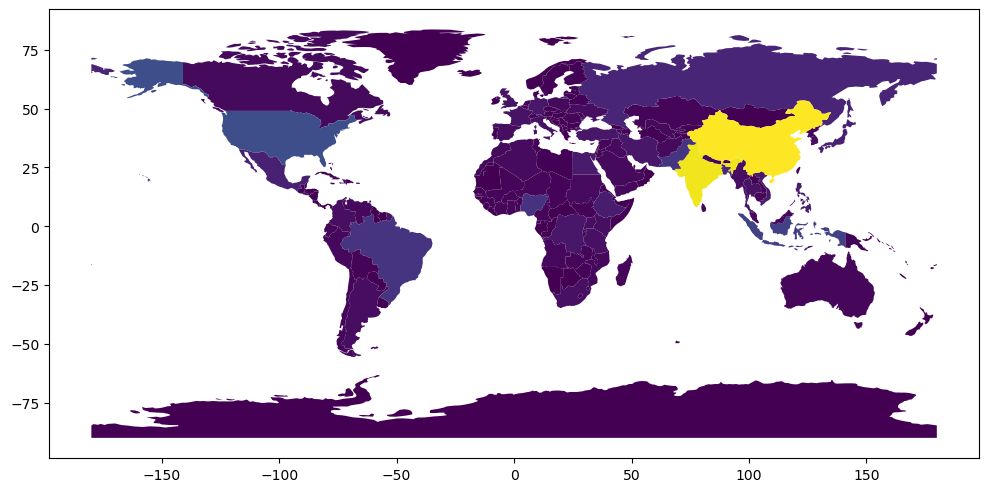

In [4]:
f,ax = plt.subplots(1,1,figsize=(12,6))
natearth.plot('pop_est', ax=ax)

为了简化操作，我们将只考虑国家中心点之间的欧氏距离，但（理论上）通过指定 "度量 "参数，我们可以在此函数中使用任何我们想要的距离。

In [5]:
coordinates = numpy.column_stack((natearth.centroid.x, natearth.centroid.y))

C:\Users\24365\AppData\Local\Temp\ipykernel_6500\1532125644.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coordinates = numpy.column_stack((natearth.centroid.x, natearth.centroid.y))


为了获得更多的结果信息，我们可以使用 `return_all` 来获得孤立峰的等级和距离。这也会返回该峰值与其最近的更高峰值之间的差距。

In [6]:
iso = topo.isolation(natearth.pop_est, coordinates, return_all=True)

在引擎盖下，该算法使用`rtree`和`numpy.sort`将观测数据按等级顺序插入`SpatialIndex()`。向下迭代时，会在 `SpatialIndex()` 中找到最近的较高观测值，并将其作为该观测值的父观测值。 随着迭代，"pop_est "越来越小，越来越多的条目被添加到 "rtree "中。

将这些数据合并到我们现有的数据中，我们就可以将其可视化了。

In [7]:
natearth = (natearth.merge(iso, left_index=True, right_index=True)
           )

因此，您可以看到中国的*隔离*是无限的，因为没有人口更多的国家。然而，印度的隔离度只是中国到印度的距离（27）。而美国的隔离度要大得多，它反映了美国到印度的距离（恰好比中国近）。人口第四多的国家印度尼西亚比印度更靠近中国，因此其 "父等级 "为 0，其 "隔离度 "为印度尼西亚到中国的距离。最后，人口第五大国巴西的 "父辈 "是美国，其 "隔离度 "为 82。

In [8]:
natearth[['continent', 'name', 'rank', 
          'pop_est', 'parent_rank', 'isolation',
          'gap']].sort_values('pop_est', ascending=False).head()

,continent,name,rank,pop_est,parent_rank,isolation,gap
139,Asia,China,0.0,1.397715e+09,NaN,NaN,NaN
98,Asia,India,1.0,1.366418e+09,0.0,27.852795,3.129725e+07
4,North America,United States of America,2.0,3.282395e+08,1.0,193.538522,1.038178e+09
8,Asia,Indonesia,3.0,2.706256e+08,0.0,41.072699,1.127089e+09
102,Asia,Pakistan,4.0,2.165653e+08,1.0,12.381725,1.149852e+09


将其可视化如下，我们得到以下结果：

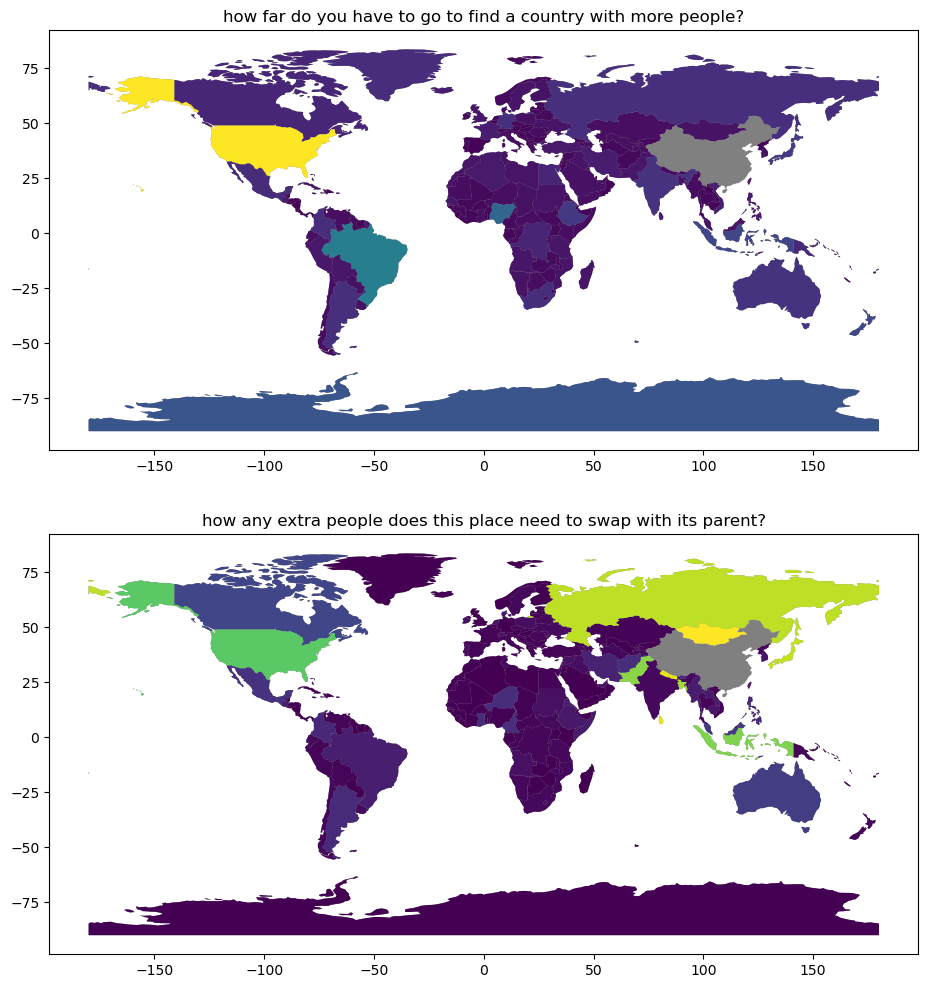

In [9]:
f,ax = plt.subplots(2,1,figsize=(12,12))
for i in range(2):
    natearth.plot(color='grey', ax=ax[i])
natearth.plot('isolation', ax=ax[0])
natearth.plot('gap', ax=ax[1])
ax[0].set_title('how far do you have to go to find a country with more people?')
ax[1].set_title('how any extra people does this place need to swap with its parent?')
plt.show()

接下来，要查看 `prominence`，我们将使用相同的参数。不过，"prominence "也可以使用指定采样位置之间联系的 graph/`libpysal.weights.W` 对象。如果没有提供预先存在的图形或曲面，则会在所提供的坐标之间使用 Delaunay 三角测量法，这是数字高程模型中常用的三角测量法。在这里，为了便于解释，我将使用鲁克毗连图。这意味着一些岛屿会自动被视为 "山峰"，因为它们与更高的观测点没有任何边界。

In [10]:
w_rook = weights.Rook.from_dataframe(natearth)
prominence = topo.prominence(natearth.pop_est, w_rook, return_all=True)

d:\work\miniconda3\envs\esda\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 25 disconnected components.
 There are 21 islands with ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175.
  warnings.warn(message)
d:\work\miniconda3\envs\esda\lib\site-packages\esda\topo.py:332: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  best_peak = most_common_value(this_unique_preds).mode.item()


在幕后，该算法对于大数据可能需要更长的时间，因此您可以使用“progressbar”选项来可视化进度。

实际的算法需要对数据进行排序，并确定每次引入等于海平面 $w$ 下降的新观测值时是否将峰值“连接”在一起。 我们通过为每个“峰值”创建一组“邻居”，避免每次迭代重新计算“scipy.sparse.connected_components”。 当两个（或更多）峰值合并时，我们用峰值“(i,j)”替换独立峰值“i”和“j”（其中 $h_i > h_j$）。 每次合并时，新峰值都会获得相邻子峰值的并集，然后从那时起将其视为单个“峰值”。

我们以与以前相同的方式将其合并回我们的数据中：

In [11]:
natearth = natearth.merge(prominence, left_index=True, right_index=True, suffixes=("","_prom"))

这给了我们下表。 我将显示比平常更多的行，以便我们可以更清楚地解释它。

In [12]:
natearth[['continent', 'name', 'pop_est', 
          'rank', 'parent_rank', 'isolation',
          'dominating_peak', 'keycol', 'prominence']].sort_values('pop_est', ascending=False).head(20)

,continent,name,pop_est,rank,parent_rank,isolation,dominating_peak,keycol,prominence
139,Asia,China,1.397715e+09,0.0,NaN,NaN,139.0,107.0,1.314801e+09
98,Asia,India,1.366418e+09,1.0,0.0,27.852795,139.0,-1.0,NaN
4,North America,United States of America,3.282395e+08,2.0,1.0,193.538522,139.0,33.0,3.239931e+08
8,Asia,Indonesia,2.706256e+08,3.0,0.0,41.072699,4.0,148.0,2.386758e+08
102,Asia,Pakistan,2.165653e+08,4.0,1.0,12.381725,139.0,-1.0,NaN
29,South America,Brazil,2.110495e+08,5.0,2.0,82.093057,8.0,43.0,1.439896e+08
56,Africa,Nigeria,2.009636e+08,6.0,5.0,64.353456,29.0,55.0,1.776529e+08
99,Asia,Bangladesh,1.630462e+08,7.0,1.0,10.713323,139.0,-1.0,NaN
18,Europe,Russia,1.443735e+08,8.0,0.0,26.373993,139.0,-1.0,NaN
27,North America,Mexico,1.275755e+08,9.0,2.0,23.966775,4.0,-1.0,NaN


这些是人口排名前 20 的国家。 沿着一排排走下去，你会发现中国有一个“NaN”的隔离度和与其人口完全相等的突出度。 印度与中国接壤。 因此，当我们将海平面“降低”到印度露出水面的位置时，它已经与最高峰中国相连。 所以，它的“显着性”并不是很大。 事实上，它被认为是“中国”山的一个“斜坡”，它的“domining_peak”是139，即“中国”的指数。 然而，美国的突出程度（令人困惑地）是根据相对于巴拿马人口的高度来计算的，因为巴拿马将其与南美洲连接起来，而法属圭亚那则在该图中连接了北美洲/南美洲和欧亚大陆。 同样，印度尼西亚也具有从马来西亚开始的突出地位，马来西亚将其与亚洲相连，并在那里遇到了以中国为基地的子图。

为了直观地了解什么是“关键列”，我们正在考虑以下图表序列中断开的国家/地区连接起来的点。 在每张图中，只有“红色”轮廓的国家/地区位于“水线”$w$ 之上。

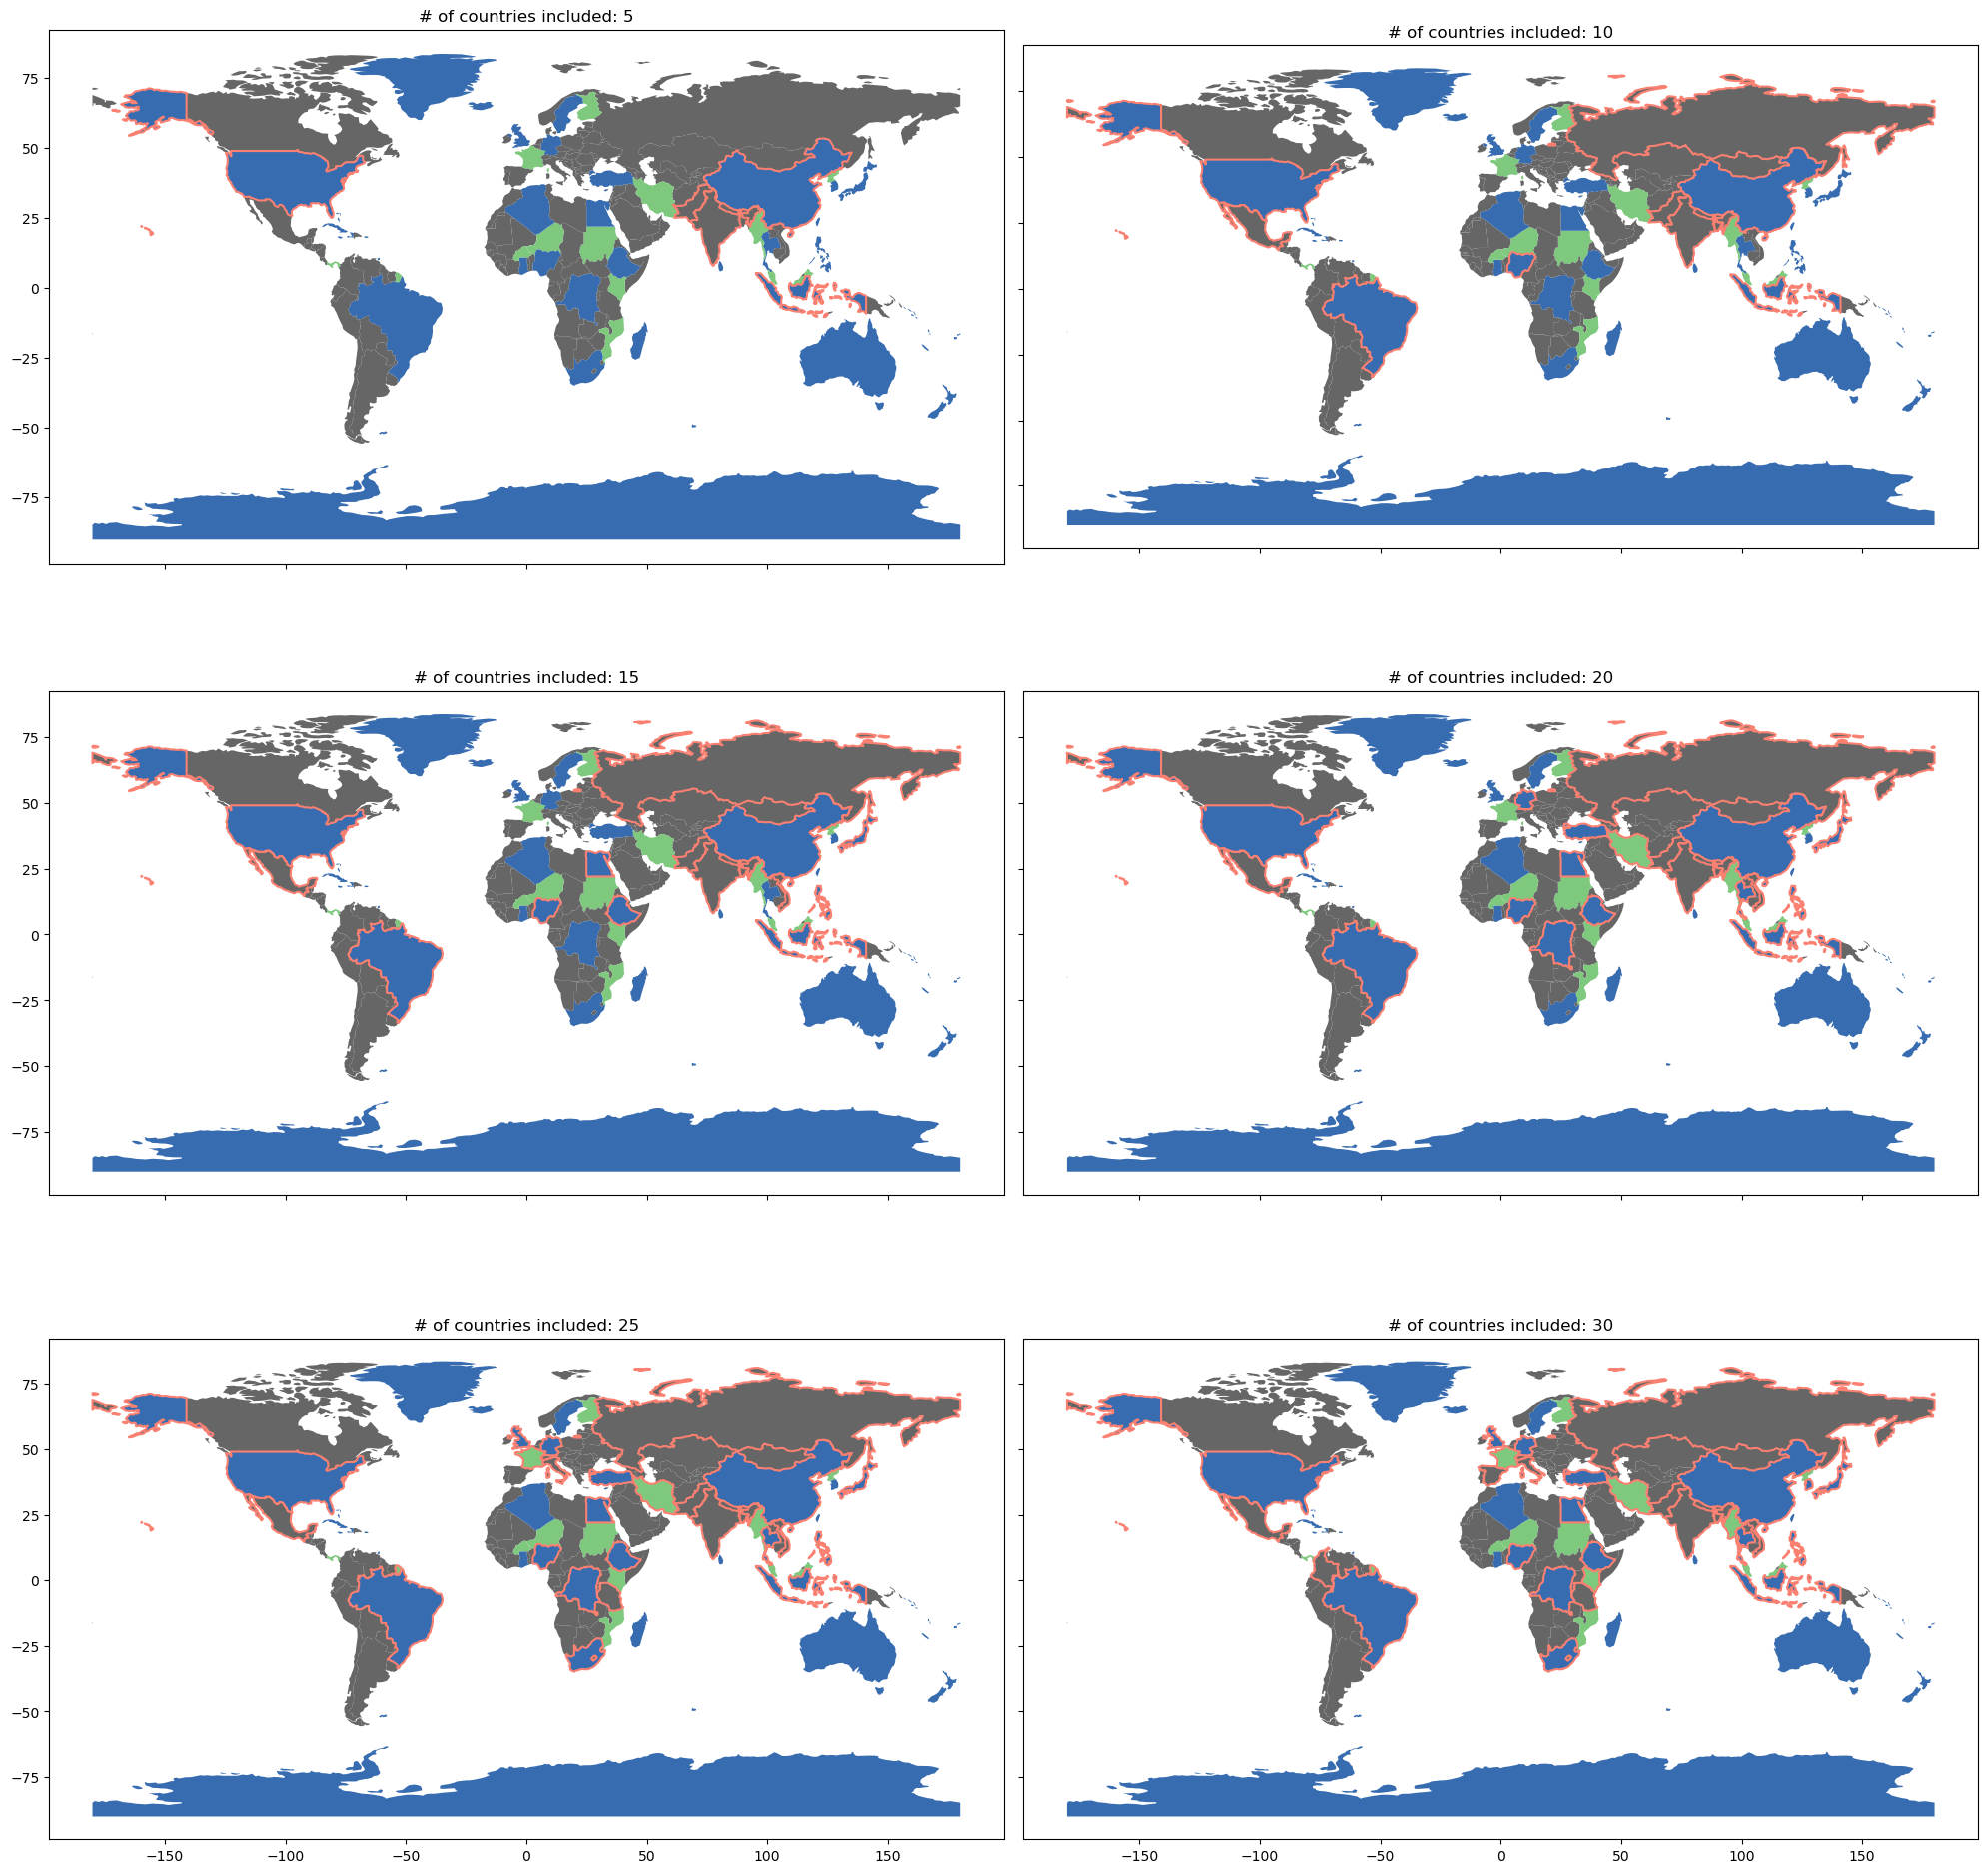

In [13]:
f,ax = plt.subplots(3,2, figsize=(20,20), sharex=True, sharey=True)
ax=ax.flatten()
for ix, rank in enumerate(range(5,31, 5)):
    natearth.plot('classification', ax=ax[ix], cmap='Accent')
    natearth.sort_values('pop_est', ascending=False).iloc[0:rank].boundary.plot(color='salmon', ax=ax[ix])
    ax[ix].set_title(f"# of countries included: {rank}")
f.tight_layout()
plt.show()

您可以看到，第一个“关键”国家/地区法国被包含在 25 个国家/地区的范围内，而在此之前，大多数包含的国家/地区都是“高峰”，彼此之间没有联系。 下面，您可以看到完整的分类图，以及每个国家/地区的重要性。

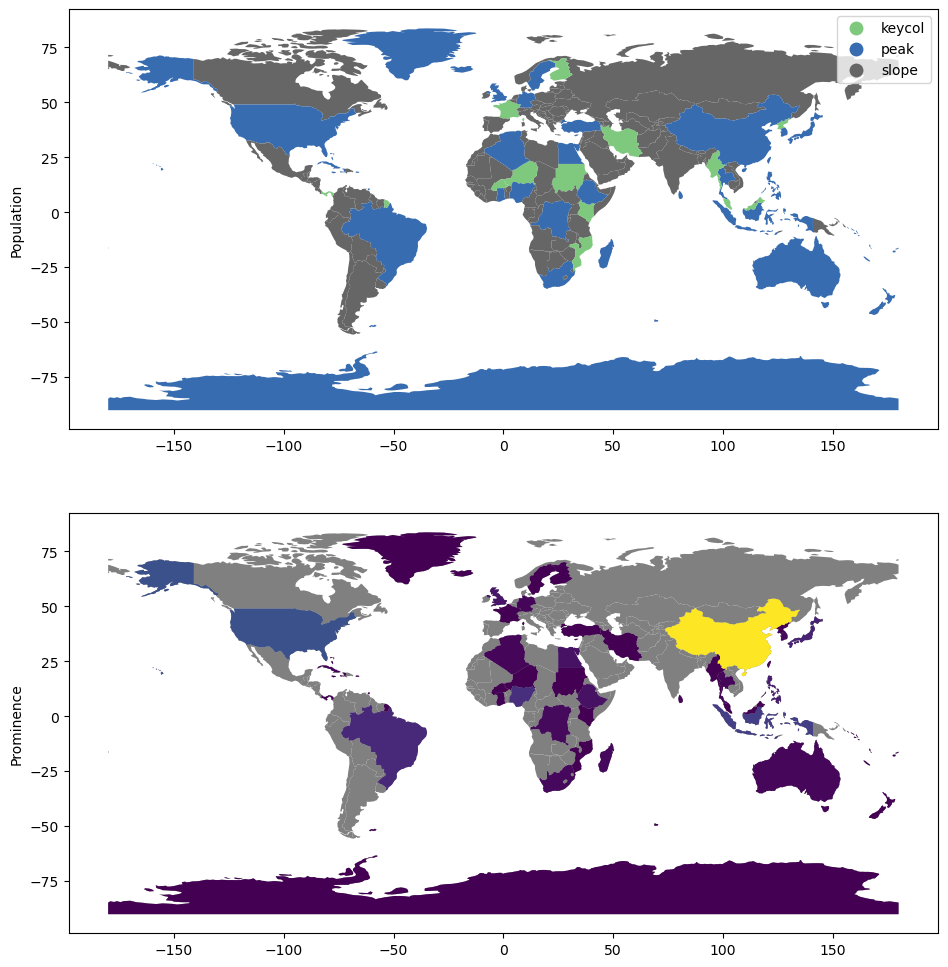

In [14]:
f,ax = plt.subplots(2,1,figsize=(12,12))
natearth.plot('classification', ax=ax[0], legend=True, cmap='Accent')
natearth.plot(color='grey', ax=ax[1])
natearth.plot('prominence', ax= ax[1])
ax[0].set_ylabel('Population')
ax[1].set_ylabel('Prominence')
plt.show()